# MIT Movie Dataset - ELMO Models

This notebook contains the code to train the ELMO model on the MIT movie dataset. 

For a brief overview of ELMO please visit: https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/


This model and the code to construct the model was based on the blog post: https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/


In [ ]:
import pandas as pd
import numpy as np

# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

#os.chdir('/content/drive/My Drive/Colab Notebooks/DAAN888/data')
os.chdir('/content/drive/My Drive/DAAN888/data')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1tuCnSXHVzIUUyCjMTEqmKbY7JxKZ-5eU/DAAN888/data'

In [ ]:
#model_dir = '/content/drive/My Drive/Colab Notebooks/DAAN888/models/'
#data_dir = '/content/drive/My Drive/Colab Notebooks/DAAN888/data/'

model_dir = '/content/drive/My Drive/DAAN888/models/'
data_dir = '/content/drive/My Drive/DAAN888/data/'

In [ ]:
#%tensorflow_version 1.14.0
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#!pip install tensorflow==1.15.0
#!pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

1.15.2
2.2.4-tf


### Load Data

In [ ]:
import pickle 

with open('mitmovie.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [ ]:
dataset.keys()

dict_keys(['train_tokens', 'train_labels', 'test_tokens', 'test_labels'])

In [ ]:
dataset['train_tokens'][0]

['what', 'movies', 'star', 'bruce', 'willis']

In [ ]:
# first row in train set
list(zip(dataset['train_tokens'][0], dataset['train_labels'][0]))

[('what', 'O'),
 ('movies', 'O'),
 ('star', 'O'),
 ('bruce', 'B-ACTOR'),
 ('willis', 'I-ACTOR')]

### Pad Tokens

In [ ]:
# maximum number of tokens in a doc
# The largest query in MIT Movie dataset has 47 words 
max_len = 50

In [ ]:
new_X = []
for seq in dataset['train_tokens']:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
    
x_train = np.array(new_X)

In [ ]:
new_X = []
for seq in dataset['test_tokens']:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
    
x_test = np.array(new_X)

In [ ]:
print(x_train[0])

['what' 'movies' 'star' 'bruce' 'willis' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__']


In [ ]:
len(x_train), len(x_test)

(9775, 2443)

In [ ]:
print(x_test[0])

['are' 'there' 'any' 'good' 'romantic' 'comedies' 'out' 'right' 'now'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__']


### Encode the Labels

In [ ]:
labels_stretched = [label for doc in dataset['train_labels'] for label in doc]

In [ ]:
# encoding is to get an integer for each tag
tag2idx = {t: i for i, t in enumerate(np.unique(labels_stretched))}
tag2idx

{'B-ACTOR': 0,
 'B-CHARACTER': 1,
 'B-DIRECTOR': 2,
 'B-GENRE': 3,
 'B-PLOT': 4,
 'B-RATING': 5,
 'B-RATINGS_AVERAGE': 6,
 'B-REVIEW': 7,
 'B-SONG': 8,
 'B-TITLE': 9,
 'B-TRAILER': 10,
 'B-YEAR': 11,
 'I-ACTOR': 12,
 'I-CHARACTER': 13,
 'I-DIRECTOR': 14,
 'I-GENRE': 15,
 'I-PLOT': 16,
 'I-RATING': 17,
 'I-RATINGS_AVERAGE': 18,
 'I-REVIEW': 19,
 'I-SONG': 20,
 'I-TITLE': 21,
 'I-TRAILER': 22,
 'I-YEAR': 23,
 'O': 24}

In [ ]:
idx2tag = {i: t for t,i in tag2idx.items()}

In [ ]:
y_train = [[tag2idx[t] for t in doc] for doc in dataset['train_labels']]
y_test = [[tag2idx[t] for t in doc] for doc in dataset['test_labels']]

In [ ]:
dataset['train_labels'][0]

['O', 'O', 'O', 'B-ACTOR', 'I-ACTOR']

In [ ]:
y_train[0]

[24, 24, 24, 0, 12]

In [ ]:
from keras.preprocessing.sequence import pad_sequences

y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

Using TensorFlow backend.


In [ ]:
y_train[0]

array([24, 24, 24,  0, 12, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
      dtype=int32)

In [ ]:
# resulting encoding of the labels
y_train.shape, y_test.shape

((9775, 50), (2443, 50))

In [ ]:
# length comparison to original dataset
len(dataset['train_labels']), len(dataset['test_labels'])

(9775, 2443)

In [ ]:
# reshape the targets

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [ ]:
y_train.shape, y_test.shape

((9775, 50, 1), (2443, 50, 1))

## Elmo + BiLSTM

In [ ]:
import tensorflow_hub as hub
from keras import backend as K

In [ ]:
K.clear_session()

sess = tf.Session()
K.set_session(sess)

In [ ]:
#!pip install -U keras-tuner
#import kerastuner as kt

In [ ]:
# Important hyperparameter
batch_size = 32
hp_units = 16*batch_size #512
hp_recurrent_dropout=0.1
hp_dropout=0.1
hp_activation="softmax"
hp_learning_rate=0.001


In [ ]:
num_labels = len(tag2idx.keys())

In [ ]:
y_train.shape[0]

9775

In [ ]:
# trim train set to be divisible by batch_size
remainder = y_train.shape[0] % batch_size
cutoff = y_train.shape[0] - remainder

train_limit = cutoff - batch_size*50 # take 100 batches to validate on

print('train_limit',train_limit)
print('cutoff',cutoff)

x_final_train = x_train[0:train_limit]
y_final_train = y_train[0:train_limit]

x_val = x_train[train_limit:cutoff]
y_val = y_train[train_limit:cutoff]


len(x_final_train), y_final_train.shape # , len(x_val), y_val.shape

train_limit 8160
cutoff 9760


(8160, (8160, 50, 1))

In [ ]:
print('train.shape[0]',y_train.shape[0])
print('batch_size',batch_size)
print('remainder',remainder)
print('cutoff',cutoff)
print('cutoff/batch_size',cutoff/batch_size)
print('train_limit = cutoff - batch_size*50',cutoff - batch_size*50)
print('cutoff-train_limit:',cutoff-train_limit)


train.shape[0] 9775
batch_size 32
remainder 15
cutoff 9760
cutoff/batch_size 305.0
train_limit = cutoff - batch_size*50 8160
cutoff-train_limit: 1600


### Train the model

In [ ]:
#!pip install -q -U keras-tuner
#import kerastuner as kt

In [ ]:
model_name = 'mitmovie_elmo/elmo_biLSTM_5epochs_Opt'

In [ ]:
# retrieve elmo word embeddings
# https://tfhub.dev/google/elmo/3

elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
print('batch_size',batch_size)
print('[max_len]',[max_len])
print('batch_size*[max_len]',batch_size*[max_len])

batch_size 32
[max_len] [50]
batch_size*[max_len] [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


In [ ]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)), # passing the pretokenized words to the model
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Dropout, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
import keras.layers as layers
from keras.engine import Layer
from tensorflow import keras
from keras import optimizers

In [ ]:
print("batch_size",batch_size)
print("hp_units",hp_units)
print("hp_recurrent_dropout",hp_recurrent_dropout)
print("hp_dropout",hp_dropout)
print("hp_activation",hp_activation)
print("hp_learning_rate",hp_learning_rate)


batch_size 32
hp_units 512
hp_recurrent_dropout 0.1
hp_dropout 0.1
hp_activation softmax
hp_learning_rate 0.001


In [ ]:
# Function to build model
#def model_builder(hp_units = 512,hp_recurrent_dropout=0.2,hp_dropout=0.1,hp_activation="softmax",hp_learning_rate=0.001):
def model_builder(batch_size=batch_size,hp_units = hp_units,hp_recurrent_dropout=hp_recurrent_dropout,hp_dropout=hp_dropout,hp_activation=hp_activation,hp_learning_rate=hp_learning_rate):
#  hp_units = 512
#  hp_recurrent_dropout=0.1
#  hp_dropout=0.1
#  hp_activation="softmax"
#  hp_learning_rate=0.001


  input_text = Input(shape=(max_len,), dtype=tf.string)

  embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)

#  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
#  hp_units = 512
#  hp_recurrent_dropout=0.1
#  hp_dropout=0.1

  x = Bidirectional(LSTM(units=hp_units, return_sequences=True,
                      recurrent_dropout=hp_recurrent_dropout, dropout=hp_dropout))(embedding)

  x_rnn = Bidirectional(LSTM(units=hp_units, return_sequences=True,
                          recurrent_dropout=hp_recurrent_dropout, dropout=hp_dropout))(x)

  x = add([x, x_rnn])  # residual connection to the first biLSTM
#  hp_activation="softmax"
  out = TimeDistributed(Dense(num_labels, activation=hp_activation))(x)

  model = Model(input_text, out)

# instead of learning_rate=0.001
#hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

#  adam_opt = optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4]))
#  hp_learning_rate=0.001
  adam_opt = optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(optimizer=adam_opt, 
              loss="sparse_categorical_crossentropy",
#              metrics=["accuracy"],
              metrics=['sparse_categorical_accuracy'])
  
  model.summary() # print model summary

  return model




Use this section for gridsearchcv

In [ ]:
keras_reg=keras.wrappers.scikit_learn.KerasRegressor(model_builder)

In [ ]:
#history=keras_reg.fit(x_final_train, y_final_train, 
#                    validation_data = (x_val, y_val), 
#                    batch_size = batch_size, 
#                    epochs = 5)

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [ ]:
#scoring = {'F1': 'f1', 'Accuracy': make_scorer(accuracy_score)}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
#param_distribs={
#    "hp_learning_rate": reciprocal(1e-4,1e-3, 1e-2),
#    "hp_dropout": [0.1,0.2],
#    "hp_recurrent_dropout": [0.1,0.2],
#    "hp_learning_rate": [5e-4, 1e-3, 1e-2],
#    "epochs": [3,5,7,9],
#    "hp_units": [256,512]
#
#}

In [ ]:
epochs=3
print('epochs',epochs)
print('batch_size', batch_size)

epochs 3
batch_size 32


In [ ]:
print(len(x_val))
print(len(y_val))

1600
1600


In [ ]:
print(len(x_final_train))
print(len(y_final_train))

8160
8160


In [ ]:
print('hp_units',hp_units)

hp_units 512


In [ ]:
param_distribs={
#   "hp_learning_rate": reciprocal(1e-4, 1e-3, 1e-2),
    "hp_dropout": [0.1,0.2],
    "hp_recurrent_dropout": [0.1,0.2],
#    "hp_learning_rate": [1e-4, 5e-4, 1e-3, 2e-3, 3e-3],
    "epochs": [3,4,5],
#    "hp_units": [256,512,1024]
}

In [ ]:

#rnd_search_cv=RandomizedSearchCV(keras_reg, param_distribs, n_iter=1, cv=5, verbose=1)
#epochs = [10, 50, 100]
#param_grid = dict(batch_size=batch_size, epochs=epochs)

#grid_search_cv=GridSearchCV(keras_reg, param_distribs,cv=3,return_train_score=True,verbose=10)
grid_search_cv=RandomizedSearchCV(keras_reg, param_distribs,cv=3,return_train_score=True,verbose=10)
grid_search_cv.fit(x_final_train, y_final_train, 
                    validation_data = (x_val, y_val), 
                    batch_size = batch_size,
#                    epochs=epochs,
                    callbacks=[keras.callbacks.EarlyStopping(patience=8)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] hp_recurrent_dropout=0.1, hp_dropout=0.1, epochs=4 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 1024)   0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 1024)   6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 1024)   6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 1024)   0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, None, 1024)   6295552     lambda_2[0][0]                   
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, None, 1024)   6295552     bidirectional_3[0][0]            
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.5min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, 1024)   0           input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, None, 1024)   6295552     lambda_3[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, None, 1024)   6295552     bidirectional_5[0][0]            
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.3min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, None, 1024)   0           input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, None, 1024)   6295552     lambda_4[0][0]                   
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, None, 1024)   6295552     bidirectional_7[0][0]            
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 22.0min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, 1024)   0           input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, None, 1024)   6295552     lambda_5[0][0]                   
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, None, 1024)   6295552     bidirectional_9[0][0]            
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.6min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, None, 1024)   0           input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, None, 1024)   6295552     lambda_6[0][0]                   
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, None, 1024)   6295552     bidirectional_11[0][0]           
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 31.2min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, None, 1024)   0           input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, None, 1024)   6295552     lambda_7[0][0]                   
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, None, 1024)   6295552     bidirectional_13[0][0]           
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 37.0min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, None, 1024)   0           input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, None, 1024)   6295552     lambda_8[0][0]                   
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, None, 1024)   6295552     bidirectional_15[0][0]           
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 42.8min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, None, 1024)   0           input_9[0][0]                    
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, None, 1024)   6295552     lambda_9[0][0]                   
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, None, 1024)   6295552     bidirectional_17[0][0]           
____________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 48.6min remaining:    0.0s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, None, 1024)   0           input_10[0][0]                   
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, None, 1024)   6295552     lambda_10[0][0]                  
__________________________________________________________________________________________________
bidirectional_20 (Bidirectional (None, None, 1024)   6295552     bidirectional_19[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, None, 1024)   0           input_11[0][0]                   
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, None, 1024)   6295552     lambda_11[0][0]                  
__________________________________________________________________________________________________
bidirectional_22 (Bidirectional (None, None, 1024)   6295552     bidirectional_21[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, None, 1024)   0           input_12[0][0]                   
__________________________________________________________________________________________________
bidirectional_23 (Bidirectional (None, None, 1024)   6295552     lambda_12[0][0]                  
__________________________________________________________________________________________________
bidirectional_24 (Bidirectional (None, None, 1024)   6295552     bidirectional_23[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, None, 1024)   0           input_13[0][0]                   
__________________________________________________________________________________________________
bidirectional_25 (Bidirectional (None, None, 1024)   6295552     lambda_13[0][0]                  
__________________________________________________________________________________________________
bidirectional_26 (Bidirectional (None, None, 1024)   6295552     bidirectional_25[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, None, 1024)   0           input_14[0][0]                   
__________________________________________________________________________________________________
bidirectional_27 (Bidirectional (None, None, 1024)   6295552     lambda_14[0][0]                  
__________________________________________________________________________________________________
bidirectional_28 (Bidirectional (None, None, 1024)   6295552     bidirectional_27[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, None, 1024)   0           input_15[0][0]                   
__________________________________________________________________________________________________
bidirectional_29 (Bidirectional (None, None, 1024)   6295552     lambda_15[0][0]                  
__________________________________________________________________________________________________
bidirectional_30 (Bidirectional (None, None, 1024)   6295552     bidirectional_29[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, None, 1024)   0           input_16[0][0]                   
__________________________________________________________________________________________________
bidirectional_31 (Bidirectional (None, None, 1024)   6295552     lambda_16[0][0]                  
__________________________________________________________________________________________________
bidirectional_32 (Bidirectional (None, None, 1024)   6295552     bidirectional_31[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, None, 1024)   0           input_17[0][0]                   
__________________________________________________________________________________________________
bidirectional_33 (Bidirectional (None, None, 1024)   6295552     lambda_17[0][0]                  
__________________________________________________________________________________________________
bidirectional_34 (Bidirectional (None, None, 1024)   6295552     bidirectional_33[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, None, 1024)   0           input_18[0][0]                   
__________________________________________________________________________________________________
bidirectional_35 (Bidirectional (None, None, 1024)   6295552     lambda_18[0][0]                  
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, None, 1024)   6295552     bidirectional_35[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, None, 1024)   0           input_19[0][0]                   
__________________________________________________________________________________________________
bidirectional_37 (Bidirectional (None, None, 1024)   6295552     lambda_19[0][0]                  
__________________________________________________________________________________________________
bidirectional_38 (Bidirectional (None, None, 1024)   6295552     bidirectional_37[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_20 (Lambda)              (None, None, 1024)   0           input_20[0][0]                   
__________________________________________________________________________________________________
bidirectional_39 (Bidirectional (None, None, 1024)   6295552     lambda_20[0][0]                  
__________________________________________________________________________________________________
bidirectional_40 (Bidirectional (None, None, 1024)   6295552     bidirectional_39[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, None, 1024)   0           input_21[0][0]                   
__________________________________________________________________________________________________
bidirectional_41 (Bidirectional (None, None, 1024)   6295552     lambda_21[0][0]                  
__________________________________________________________________________________________________
bidirectional_42 (Bidirectional (None, None, 1024)   6295552     bidirectional_41[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, None, 1024)   0           input_22[0][0]                   
__________________________________________________________________________________________________
bidirectional_43 (Bidirectional (None, None, 1024)   6295552     lambda_22[0][0]                  
__________________________________________________________________________________________________
bidirectional_44 (Bidirectional (None, None, 1024)   6295552     bidirectional_43[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_23 (Lambda)              (None, None, 1024)   0           input_23[0][0]                   
__________________________________________________________________________________________________
bidirectional_45 (Bidirectional (None, None, 1024)   6295552     lambda_23[0][0]                  
__________________________________________________________________________________________________
bidirectional_46 (Bidirectional (None, None, 1024)   6295552     bidirectional_45[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_24 (Lambda)              (None, None, 1024)   0           input_24[0][0]                   
__________________________________________________________________________________________________
bidirectional_47 (Bidirectional (None, None, 1024)   6295552     lambda_24[0][0]                  
__________________________________________________________________________________________________
bidirectional_48 (Bidirectional (None, None, 1024)   6295552     bidirectional_47[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_25 (Lambda)              (None, None, 1024)   0           input_25[0][0]                   
__________________________________________________________________________________________________
bidirectional_49 (Bidirectional (None, None, 1024)   6295552     lambda_25[0][0]                  
__________________________________________________________________________________________________
bidirectional_50 (Bidirectional (None, None, 1024)   6295552     bidirectional_49[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_26 (Lambda)              (None, None, 1024)   0           input_26[0][0]                   
__________________________________________________________________________________________________
bidirectional_51 (Bidirectional (None, None, 1024)   6295552     lambda_26[0][0]                  
__________________________________________________________________________________________________
bidirectional_52 (Bidirectional (None, None, 1024)   6295552     bidirectional_51[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_27 (Lambda)              (None, None, 1024)   0           input_27[0][0]                   
__________________________________________________________________________________________________
bidirectional_53 (Bidirectional (None, None, 1024)   6295552     lambda_27[0][0]                  
__________________________________________________________________________________________________
bidirectional_54 (Bidirectional (None, None, 1024)   6295552     bidirectional_53[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_28 (Lambda)              (None, None, 1024)   0           input_28[0][0]                   
__________________________________________________________________________________________________
bidirectional_55 (Bidirectional (None, None, 1024)   6295552     lambda_28[0][0]                  
__________________________________________________________________________________________________
bidirectional_56 (Bidirectional (None, None, 1024)   6295552     bidirectional_55[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_29 (Lambda)              (None, None, 1024)   0           input_29[0][0]                   
__________________________________________________________________________________________________
bidirectional_57 (Bidirectional (None, None, 1024)   6295552     lambda_29[0][0]                  
__________________________________________________________________________________________________
bidirectional_58 (Bidirectional (None, None, 1024)   6295552     bidirectional_57[0][0]           
___________________________________________________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_30 (Lambda)              (None, None, 1024)   0           input_30[0][0]                   
__________________________________________________________________________________________________
bidirectional_59 (Bidirectional (None, None, 1024)   6295552     lambda_30[0][0]                  
__________________________________________________________________________________________________
bidirectional_60 (Bidirectional (None, None, 1024)   6295552     bidirectional_59[0][0]           
___________________________________________________________________________________________

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 178.5min finished


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_31 (Lambda)              (None, None, 1024)   0           input_31[0][0]                   
__________________________________________________________________________________________________
bidirectional_61 (Bidirectional (None, None, 1024)   6295552     lambda_31[0][0]                  
__________________________________________________________________________________________________
bidirectional_62 (Bidirectional (None, None, 1024)   6295552     bidirectional_61[0][0]           
___________________________________________________________________________________________

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd7b3680be0>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'epochs': [3, 4, 5],
                                        'hp_dropout': [0.1, 0.2],
                                        'hp_recurrent_dropout': [0.1, 0.2]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring=None, verbose=10)

In [ ]:
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

-0.06561696549841002
{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0.1, 'epochs': 4}


In [ ]:
sorted(grid_search_cv.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_epochs',
 'param_hp_dropout',
 'param_hp_recurrent_dropout',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [ ]:
cvres=grid_search_cv.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(mean_score,params)                              

-0.06561696549841002 {'hp_recurrent_dropout': 0.1, 'hp_dropout': 0.1, 'epochs': 4}
-0.07206884260271111 {'hp_recurrent_dropout': 0.2, 'hp_dropout': 0.1, 'epochs': 3}
-0.07208156575467072 {'hp_recurrent_dropout': 0.2, 'hp_dropout': 0.1, 'epochs': 4}
-0.06622775790518991 {'hp_recurrent_dropout': 0.1, 'hp_dropout': 0.2, 'epochs': 3}
-0.06895397906648178 {'hp_recurrent_dropout': 0.2, 'hp_dropout': 0.2, 'epochs': 3}
-0.06671768509070664 {'hp_recurrent_dropout': 0.1, 'hp_dropout': 0.2, 'epochs': 4}
-0.0685842747380044 {'hp_recurrent_dropout': 0.2, 'hp_dropout': 0.2, 'epochs': 4}
-0.06965131324661128 {'hp_recurrent_dropout': 0.1, 'hp_dropout': 0.2, 'epochs': 5}
-0.07016287993128394 {'hp_recurrent_dropout': 0.2, 'hp_dropout': 0.1, 'epochs': 5}
-0.06732590950148946 {'hp_recurrent_dropout': 0.2, 'hp_dropout': 0.2, 'epochs': 5}


In [ ]:
model=grid_search_cv.best_estimator_.model

In [ ]:
print(model)

In [ ]:
grid_search_cv.cv_results_

{'mean_fit_time': array([285.99159296, 219.08706299, 287.99357637, 223.68718155,
        227.97186271, 298.88718033, 301.50716734, 372.7410171 ,
        377.34529877, 379.11431313]),
 'mean_score_time': array([20.05521568, 19.85269984, 19.73124599, 19.96300817, 19.93826421,
        19.84874646, 19.81058089, 19.67829744, 19.89010413, 19.71952868]),
 'mean_test_score': array([-0.06561697, -0.07206884, -0.07208157, -0.06622776, -0.06895398,
        -0.06671769, -0.06858427, -0.06965131, -0.07016288, -0.06732591]),
 'mean_train_score': array([-0.02900111, -0.03647952, -0.02974792, -0.03533128, -0.03632236,
        -0.02959749, -0.02946059, -0.02502096, -0.02388682, -0.02461898]),
 'param_epochs': masked_array(data=[4, 3, 4, 3, 3, 4, 4, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_hp_dropout': masked_array(data=[0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 

In [ ]:
pd.DataFrame(grid_search_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hp_recurrent_dropout,param_hp_dropout,param_epochs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,285.991593,1.256799,20.055216,0.080303,0.1,0.1,4,"{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0....",-0.087587,-0.074257,-0.035007,-0.065617,0.022318,1,-0.023868,-0.024633,-0.038502,-0.029001,0.006726
1,219.087063,0.935182,19.852700,0.010150,0.2,0.1,3,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.090146,-0.077449,-0.048612,-0.072069,0.017377,9,-0.029315,-0.031808,-0.048316,-0.036480,0.008431
2,287.993576,1.395853,19.731246,0.086530,0.2,0.1,4,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.095936,-0.072575,-0.047734,-0.072082,0.019682,10,-0.024982,-0.022433,-0.041828,-0.029748,0.008605
3,223.687182,2.114300,19.963008,0.136802,0.1,0.2,3,"{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0....",-0.083583,-0.073071,-0.042029,-0.066228,0.017641,2,-0.029356,-0.029194,-0.047444,-0.035331,0.008565
4,227.971863,1.556069,19.938264,0.039812,0.2,0.2,3,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.086225,-0.076218,-0.044419,-0.068954,0.017823,6,-0.029517,-0.032282,-0.047168,-0.036322,0.007752
5,298.887180,0.789586,19.848746,0.049456,0.1,0.2,4,"{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0....",-0.083380,-0.076134,-0.040639,-0.066718,0.018676,3,-0.023638,-0.024755,-0.040399,-0.029597,0.007651
6,301.507167,0.397776,19.810581,0.111908,0.2,0.2,4,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.085388,-0.072736,-0.047629,-0.068584,0.015692,5,-0.023491,-0.024232,-0.040659,-0.029461,0.007924
7,372.741017,0.983878,19.678297,0.010254,0.1,0.2,5,"{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0....",-0.090420,-0.081192,-0.037342,-0.069651,0.023155,7,-0.021391,-0.020759,-0.032913,-0.025021,0.005586
8,377.345299,1.327705,19.890104,0.135583,0.2,0.1,5,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.084554,-0.079267,-0.046668,-0.070163,0.016753,8,-0.017945,-0.021481,-0.032234,-0.023887,0.006077
9,379.114313,1.029304,19.719529,0.074574,0.2,0.2,5,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.086490,-0.076227,-0.039261,-0.067326,0.020282,4,-0.019423,-0.019630,-0.034804,-0.024619,0.007202


In [ ]:
for_bar_chart=pd.DataFrame(grid_search_cv.cv_results_)

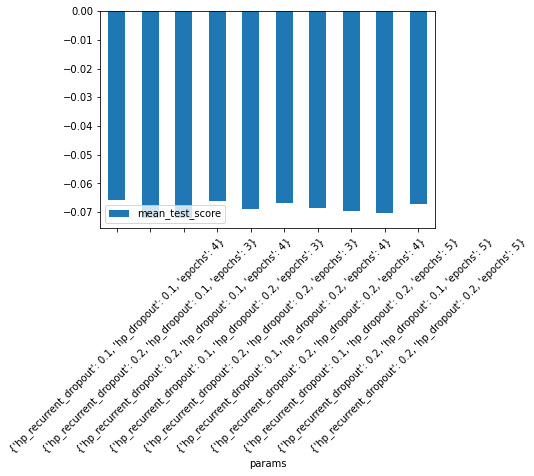

In [ ]:
ax = for_bar_chart.plot.bar(x='params', y='mean_test_score', rot=45)

In [ ]:
for_bar_chart2=pd.DataFrame([x for x in for_bar_chart['params']])
for_bar_chart2
name=for_bar_chart2.columns[0]
name

'hp_recurrent_dropout'

In [ ]:
for_bar_chart[name] = for_bar_chart2[name]
for_bar_chart

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hp_recurrent_dropout,param_hp_dropout,param_epochs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,hp_recurrent_dropout
0,285.991593,1.256799,20.055216,0.080303,0.1,0.1,4,"{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0....",-0.087587,-0.074257,-0.035007,-0.065617,0.022318,1,-0.023868,-0.024633,-0.038502,-0.029001,0.006726,0.1
1,219.087063,0.935182,19.852700,0.010150,0.2,0.1,3,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.090146,-0.077449,-0.048612,-0.072069,0.017377,9,-0.029315,-0.031808,-0.048316,-0.036480,0.008431,0.2
2,287.993576,1.395853,19.731246,0.086530,0.2,0.1,4,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.095936,-0.072575,-0.047734,-0.072082,0.019682,10,-0.024982,-0.022433,-0.041828,-0.029748,0.008605,0.2
3,223.687182,2.114300,19.963008,0.136802,0.1,0.2,3,"{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0....",-0.083583,-0.073071,-0.042029,-0.066228,0.017641,2,-0.029356,-0.029194,-0.047444,-0.035331,0.008565,0.1
4,227.971863,1.556069,19.938264,0.039812,0.2,0.2,3,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.086225,-0.076218,-0.044419,-0.068954,0.017823,6,-0.029517,-0.032282,-0.047168,-0.036322,0.007752,0.2
5,298.887180,0.789586,19.848746,0.049456,0.1,0.2,4,"{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0....",-0.083380,-0.076134,-0.040639,-0.066718,0.018676,3,-0.023638,-0.024755,-0.040399,-0.029597,0.007651,0.1
6,301.507167,0.397776,19.810581,0.111908,0.2,0.2,4,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.085388,-0.072736,-0.047629,-0.068584,0.015692,5,-0.023491,-0.024232,-0.040659,-0.029461,0.007924,0.2
7,372.741017,0.983878,19.678297,0.010254,0.1,0.2,5,"{'hp_recurrent_dropout': 0.1, 'hp_dropout': 0....",-0.090420,-0.081192,-0.037342,-0.069651,0.023155,7,-0.021391,-0.020759,-0.032913,-0.025021,0.005586,0.1
8,377.345299,1.327705,19.890104,0.135583,0.2,0.1,5,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.084554,-0.079267,-0.046668,-0.070163,0.016753,8,-0.017945,-0.021481,-0.032234,-0.023887,0.006077,0.2
9,379.114313,1.029304,19.719529,0.074574,0.2,0.2,5,"{'hp_recurrent_dropout': 0.2, 'hp_dropout': 0....",-0.086490,-0.076227,-0.039261,-0.067326,0.020282,4,-0.019423,-0.019630,-0.034804,-0.024619,0.007202,0.2


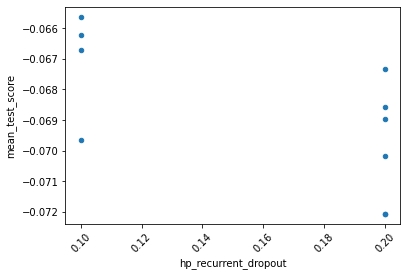

In [ ]:
ax = for_bar_chart.plot.scatter(x=name, y='mean_test_score', rot=45)

Text(0, 0.5, 'mean_test_score')

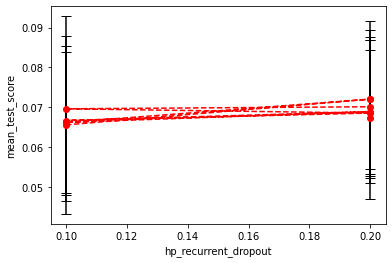

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

stdev = for_bar_chart['std_test_score']

ax.errorbar(x=for_bar_chart[name], y=-for_bar_chart['mean_test_score'], yerr=stdev, color='red', ls='--', marker='o', capsize=5, capthick=1, ecolor='black')

#ax.set_xlim(xlims)
#ax.set_ylim(ylims)
ax.set_xlabel(name)
ax.set_ylabel("mean_test_score")

In [ ]:

plt.plot(grid_search_cv.cv_results_['sparse_categorical_accuracy'])
plt.show()


KeyError: ignored

Start here if no grid search

In [ ]:
# Important hyperparameter
#batch_size = 32 # Can only be changed at the beginning of the model description
hp_units = 512
hp_recurrent_dropout=0.1
hp_dropout=0.1
hp_activation="softmax"
#hp_learning_rate=0.001
hp_learning_rate=0.001
epochs=3

In [ ]:
print(len(x_val))
print(len(y_val))

1600
1600


In [ ]:
model = model_builder(hp_units = hp_units,hp_recurrent_dropout=hp_recurrent_dropout,hp_dropout=hp_dropout,hp_activation=hp_activation,hp_learning_rate=hp_learning_rate)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, None, 1024)   0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 1024)   6295552     lambda_11[0][0]                  
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 1024)   6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

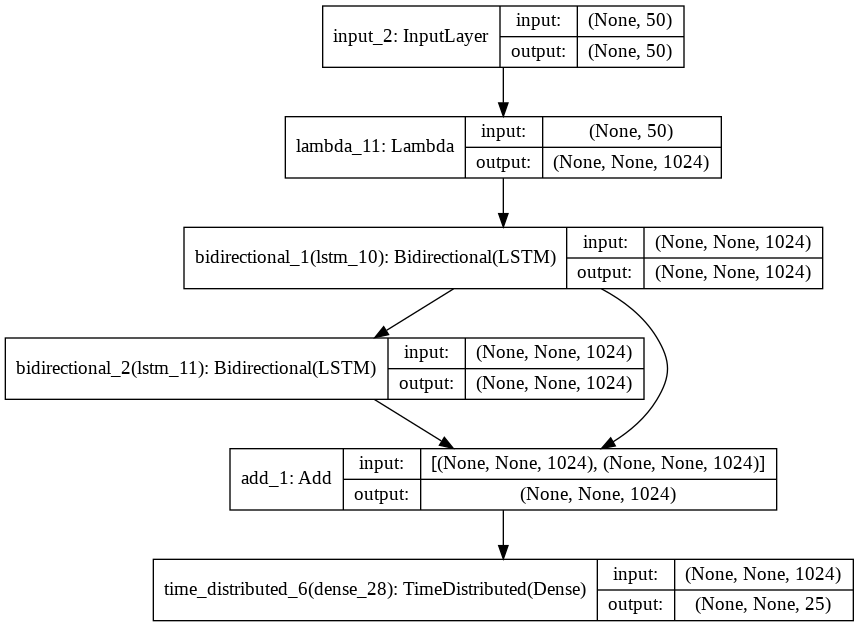

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
print("batch_size",batch_size)
print("hp_units",hp_units)
print("hp_recurrent_dropout",hp_recurrent_dropout)
print("hp_dropout",hp_dropout)
print("hp_activation",hp_activation)
print("hp_learning_rate",hp_learning_rate)
print("epochs",epochs)

batch_size 32
hp_units 512
hp_recurrent_dropout 0.1
hp_dropout 0.1
hp_activation softmax
hp_learning_rate 0.001
epochs 3


In [ ]:
history = model.fit(x_final_train, y_final_train, 
                    validation_data = (x_val, y_val), 
                    batch_size = batch_size, 
                    epochs = epochs, verbose=1)

Train on 8160 samples, validate on 1600 samples
Epoch 1/3
8160/8160 [==============================] - 108s 13ms/step - loss: 0.1390 - sparse_categorical_accuracy: 0.9648 - val_loss: 0.0508 - val_sparse_categorical_accuracy: 0.9849
Epoch 2/3
8160/8160 [==============================] - 98s 12ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.0487 - val_sparse_categorical_accuracy: 0.9852
Epoch 3/3
8160/8160 [==============================] - 99s 12ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.0424 - val_sparse_categorical_accuracy: 0.9880


In [ ]:
score = model.evaluate(x_val, y_val, verbose=1) # Only works when batch size = 32; Why?
print('Test loss:', score[0])
print('Test accuracy:', score[1]) # Does this include padding still?


1600/1600 [==============================] - 12s 7ms/step
Test loss: 0.0424128261115402
Test accuracy: 0.9880499839782715


In [ ]:
len(x_val)

1600

In [ ]:
x_val[0]

array(['what', 'is', 'a', 'must', 'see', 'film', 'by', 'dom', 'rotheroe',
       'involving', 'military', 'guerrilla', 'warfare', 'in', 'the',
       'last', 'five', 'decades', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__'],
      dtype='<U19')

In [ ]:
#?model.evaluate

In [ ]:
model.save_weights(model_dir + model_name + '.h5')

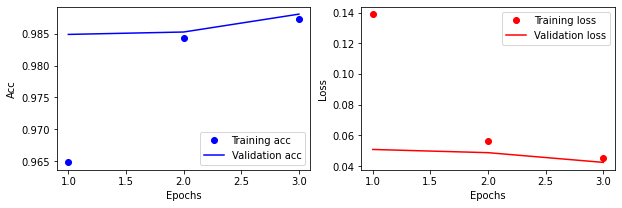

In [ ]:
# plot model fitting results
import matplotlib.pyplot as plt
#%matplotlib inline

fig = plt.figure(figsize = (10,3))

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

epochs = range(1, len(acc) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplot(1,2,2)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
fig.savefig(model_dir + model_name + '.png', dpi=400, bbox_inches='tight')

In [ ]:
history.history['val_loss']

[0.0508336166292429, 0.048744133841246366, 0.0424128261115402]

In [ ]:
history.history['val_sparse_categorical_accuracy'] #Probably includes padding

[0.9848750233650208, 0.9852499961853027, 0.9880499839782715]

### Evaluate the model

In [ ]:
print("batch_size",batch_size)
print("hp_units",hp_units)
print("hp_recurrent_dropout",hp_recurrent_dropout)
print("hp_dropout",hp_dropout)
print("hp_activation",hp_activation)
print("hp_learning_rate",hp_learning_rate)

batch_size 32
hp_units 512
hp_recurrent_dropout 0.1
hp_dropout 0.1
hp_activation softmax
hp_learning_rate 0.001


In [ ]:
print('Original test set shape:', x_test.shape)
# how many rows we need extra so that model is divisible by 32
additional_rows = batch_size - x_test.shape[0] % batch_size
x_eval = np.append(x_test, x_test[0:additional_rows], axis=0)
print('Eval test set shape:', x_eval.shape)

Original test set shape: (2443, 50)
Eval test set shape: (2464, 50)


In [ ]:
x_eval[0]

array(['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out',
       'right', 'now', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__'], dtype='<U23')

In [ ]:
model = model_builder(hp_units = hp_units,hp_recurrent_dropout=hp_recurrent_dropout,hp_dropout=hp_dropout,hp_activation=hp_activation,hp_learning_rate=hp_learning_rate)

# must initialize the model first, then load the weights
model.load_weights(model_dir + model_name + '.h5')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, None, 1024)   0           input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, None, 1024)   6295552     lambda_12[0][0]                  
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, None, 1024)   6295552     bidirectional_3[0][0]            
____________________________________________________________________________________________

In [ ]:
#epochs=7
print("epochs",epochs)

epochs range(1, 4)


In [ ]:
#history = model.fit(x_final_train, y_final_train, 
#                    validation_data = (x_val, y_val), 
#                    batch_size = batch_size, 
#                    epochs = epochs, verbose=1)

In [ ]:
score = model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) # Does this include padding still?

1600/1600 [==============================] - 13s 8ms/step
Test loss: 0.0424128261115402
Test accuracy: 0.9880499839782715


In [ ]:
x_eval

array([['are', 'there', 'any', ..., '__PAD__', '__PAD__', '__PAD__'],
       ['show', 'me', 'a', ..., '__PAD__', '__PAD__', '__PAD__'],
       ['list', 'the', 'five', ..., '__PAD__', '__PAD__', '__PAD__'],
       ...,
       ['list', 'pg', 'rated', ..., '__PAD__', '__PAD__', '__PAD__'],
       ['what', 'movie', 'won', ..., '__PAD__', '__PAD__', '__PAD__'],
       ['find', 'me', 'childrens', ..., '__PAD__', '__PAD__', '__PAD__']],
      dtype='<U23')

In [ ]:
len(x_eval)

2464

In [ ]:
trim_tokens = []
for i, doc in enumerate(x_eval):
  trim_tokens.append(x_eval[i][0:len(doc)]) 

In [ ]:
trim_tokens

[array(['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out',
        'right', 'now', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__'], dtype='<U23'),
 array(['show', 'me', 'a', 'movie', 'about', 'cars', 'that', 'talk',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
        '__PAD__',

In [ ]:
trim_tokens[0][0]

'are'

In [ ]:
trim_tokens[0][1]

'there'

In [ ]:
len(trim_tokens)

2464

In [ ]:
trim_tokens[5]

array(['show', 'me', '1980s', 'action', 'movies', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__'], dtype='<U23')

In [ ]:
i=0
j=5
for x in trim_tokens[j]:
  if trim_tokens[j][i] != '__PAD__':
    print('the word is:',trim_tokens[j][i])
    i=i+1

the word is: show
the word is: me
the word is: 1980s
the word is: action
the word is: movies


In [ ]:
i=0
j=0

actual_words=[]

for x in trim_tokens:
  for x in trim_tokens[j]:
    if trim_tokens[j][i] != '__PAD__':
#      print('the word is:',trim_tokens[j][i])
      actual_words.append(trim_tokens[j][i])
      i=i+1
  j=j+1
  i=0



In [ ]:
len(actual_words)

24871

In [ ]:
print(j)

2464


In [ ]:
preds = model.predict(x_eval, batch_size=batch_size)
preds = np.argmax(preds, axis=-1)


In [ ]:
len(preds)

2464

In [ ]:
len(x_eval)

2464

In [ ]:
print('Initial preds shape:', preds.shape)
preds = preds[0:x_test.shape[0]]
print('Trimmed to original preds shape:', preds.shape)

Initial preds shape: (2464, 50)
Trimmed to original preds shape: (2443, 50)


In [ ]:
# trim the length of docs back to the number of words to predict
trim_preds = []
for i, doc in enumerate(dataset['test_tokens']):
  trim_preds.append(preds[i][0:len(doc)])  

In [ ]:
len(trim_preds)

2443

In [ ]:
trim_preds[0] # no words

array([24, 24, 24, 24,  3, 15, 24, 24, 24])

In [ ]:
len(x_test)

2443

In [ ]:
x_test[0]

array(['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out',
       'right', 'now', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',
       '__PAD__'], dtype='<U23')

In [ ]:
trim_tokens = []
for i, doc in enumerate(x_test):
  trim_tokens.append(x_test[i][0:len(doc)]) 

In [ ]:
len(trim_tokens)

2443

In [ ]:
i=0
j=0

actual_words=[]

for x in trim_tokens:
  for x in trim_tokens[j]:
    if trim_tokens[j][i] != '__PAD__':
#      print('the word is:',trim_tokens[j][i])
      actual_words.append(trim_tokens[j][i])
      i=i+1
  j=j+1
  i=0



In [ ]:
len(actual_words)

24686

In [ ]:
idx2tag

{0: 'B-ACTOR',
 1: 'B-CHARACTER',
 2: 'B-DIRECTOR',
 3: 'B-GENRE',
 4: 'B-PLOT',
 5: 'B-RATING',
 6: 'B-RATINGS_AVERAGE',
 7: 'B-REVIEW',
 8: 'B-SONG',
 9: 'B-TITLE',
 10: 'B-TRAILER',
 11: 'B-YEAR',
 12: 'I-ACTOR',
 13: 'I-CHARACTER',
 14: 'I-DIRECTOR',
 15: 'I-GENRE',
 16: 'I-PLOT',
 17: 'I-RATING',
 18: 'I-RATINGS_AVERAGE',
 19: 'I-REVIEW',
 20: 'I-SONG',
 21: 'I-TITLE',
 22: 'I-TRAILER',
 23: 'I-YEAR',
 24: 'O'}

In [ ]:
dataset['test_labels']

[['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'B-YEAR', 'I-YEAR'],
 ['O', 'O', 'O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT'],
 ['O',
  'O',
  'B-RATINGS_AVERAGE',
  'I-RATINGS_AVERAGE',
  'O',
  'O',
  'O',
  'B-ACTOR',
  'I-ACTOR'],
 ['O', 'B-GENRE', 'I-GENRE', 'O', 'O', 'O', 'O', 'B-YEAR'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TITLE', 'I-TITLE', 'O'],
 ['O', 'O', 'B-YEAR', 'B-GENRE', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-TITLE',
  'I-TITLE',
  'I-TITLE'],
 ['O', 'O', 'O', 'O', 'B-SONG', 'O', 'O', 'B-TITLE', 'I-TITLE', 'I-TITLE'],
 ['O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'B-YEAR', 'I-YEAR'],
 ['O', 'O', 'O', 'O', 'B-YEAR', 'O', 'O', 'B-ACTOR', 'I-ACTOR'],
 ['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'O', 'B-CHARACTER'],
 ['O', 'B-ACTOR', 'I-ACTOR', 'O', 'O', 'B-GENRE', 'O', 'O', 'B-YEAR'],
 ['O', 'O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-ACTOR', 'I-ACTOR'],
 ['O', 'O', 'O', 'B-TITLE', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 

In [ ]:
dataset.keys()

dict_keys(['train_tokens', 'train_labels', 'test_tokens', 'test_labels'])

In [ ]:
preds_stretched = [idx2tag[label] for doc in trim_preds for label in doc]
trues_stretched = [label for doc in dataset['test_labels'] for label in doc]
tokens_stretched= [label for doc in dataset['test_tokens'] for label in doc]
len(preds_stretched), len(trues_stretched), len(tokens_stretched)

(24686, 24686, 24686)

In [ ]:
tokens_stretched[0]

'are'

In [ ]:
from sklearn.metrics import classification_report


f = open(model_dir + model_name  + '_class_report_test.txt', 'w') 

class_report = classification_report(trues_stretched, preds_stretched)
print(class_report, file=f ) 

f.close() 


print(class_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.87      0.93      0.90       812
      B-CHARACTER       0.67      0.44      0.53        90
       B-DIRECTOR       0.88      0.82      0.85       456
          B-GENRE       0.92      0.95      0.93      1117
           B-PLOT       0.78      0.61      0.69       491
         B-RATING       0.97      0.97      0.97       500
B-RATINGS_AVERAGE       0.91      0.91      0.91       451
         B-REVIEW       0.35      0.12      0.18        56
           B-SONG       0.77      0.61      0.68        54
          B-TITLE       0.89      0.78      0.83       562
        B-TRAILER       0.82      0.77      0.79        30
           B-YEAR       0.95      0.94      0.94       720
          I-ACTOR       0.86      0.93      0.90       862
      I-CHARACTER       0.73      0.36      0.48        75
       I-DIRECTOR       0.88      0.84      0.86       496
          I-GENRE       0.90      0.72      0.80       

In [ ]:
class_report

'                   precision    recall  f1-score   support\n\n          B-ACTOR       0.87      0.93      0.90       812\n      B-CHARACTER       0.67      0.44      0.53        90\n       B-DIRECTOR       0.88      0.82      0.85       456\n          B-GENRE       0.92      0.95      0.93      1117\n           B-PLOT       0.78      0.61      0.69       491\n         B-RATING       0.97      0.97      0.97       500\nB-RATINGS_AVERAGE       0.91      0.91      0.91       451\n         B-REVIEW       0.35      0.12      0.18        56\n           B-SONG       0.77      0.61      0.68        54\n          B-TITLE       0.89      0.78      0.83       562\n        B-TRAILER       0.82      0.77      0.79        30\n           B-YEAR       0.95      0.94      0.94       720\n          I-ACTOR       0.86      0.93      0.90       862\n      I-CHARACTER       0.73      0.36      0.48        75\n       I-DIRECTOR       0.88      0.84      0.86       496\n          I-GENRE       0.90      0.7

In [ ]:
import pandas as pd
report = classification_report(trues_stretched, preds_stretched, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
B-ACTOR,0.865450,0.934729,0.898757,812.000000
B-CHARACTER,0.666667,0.444444,0.533333,90.000000
B-DIRECTOR,0.884706,0.824561,0.853575,456.000000
B-GENRE,0.922271,0.945389,0.933687,1117.000000
B-PLOT,0.779793,0.613035,0.686431,491.000000
B-RATING,0.971888,0.968000,0.969940,500.000000
B-RATINGS_AVERAGE,0.907489,0.913525,0.910497,451.000000
B-REVIEW,0.350000,0.125000,0.184211,56.000000
B-SONG,0.767442,0.611111,0.680412,54.000000
B-TITLE,0.892495,0.782918,0.834123,562.000000


In [ ]:
df_report.index

Index(['B-ACTOR', 'B-CHARACTER', 'B-DIRECTOR', 'B-GENRE', 'B-PLOT', 'B-RATING',
       'B-RATINGS_AVERAGE', 'B-REVIEW', 'B-SONG', 'B-TITLE', 'B-TRAILER',
       'B-YEAR', 'I-ACTOR', 'I-CHARACTER', 'I-DIRECTOR', 'I-GENRE', 'I-PLOT',
       'I-RATING', 'I-RATINGS_AVERAGE', 'I-REVIEW', 'I-SONG', 'I-TITLE',
       'I-TRAILER', 'I-YEAR', 'O', 'accuracy', 'macro avg', 'weighted avg'],
      dtype='object')

In [ ]:
text=df_report.index[0:25]
text

Index(['B-ACTOR', 'B-CHARACTER', 'B-DIRECTOR', 'B-GENRE', 'B-PLOT', 'B-RATING',
       'B-RATINGS_AVERAGE', 'B-REVIEW', 'B-SONG', 'B-TITLE', 'B-TRAILER',
       'B-YEAR', 'I-ACTOR', 'I-CHARACTER', 'I-DIRECTOR', 'I-GENRE', 'I-PLOT',
       'I-RATING', 'I-RATINGS_AVERAGE', 'I-REVIEW', 'I-SONG', 'I-TITLE',
       'I-TRAILER', 'I-YEAR', 'O'],
      dtype='object')

In [ ]:
df_report.reset_index(inplace=True)
df_report

,index,precision,recall,f1-score,support
0,B-ACTOR,0.865450,0.934729,0.898757,812.000000
1,B-CHARACTER,0.666667,0.444444,0.533333,90.000000
2,B-DIRECTOR,0.884706,0.824561,0.853575,456.000000
3,B-GENRE,0.922271,0.945389,0.933687,1117.000000
4,B-PLOT,0.779793,0.613035,0.686431,491.000000
5,B-RATING,0.971888,0.968000,0.969940,500.000000
6,B-RATINGS_AVERAGE,0.907489,0.913525,0.910497,451.000000
7,B-REVIEW,0.350000,0.125000,0.184211,56.000000
8,B-SONG,0.767442,0.611111,0.680412,54.000000
9,B-TITLE,0.892495,0.782918,0.834123,562.000000


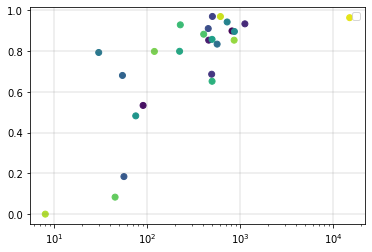

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib
from matplotlib.cm import cool
from matplotlib.cm import viridis

plt.clf()

x=df_report['support'][0:25]
y=df_report['f1-score'][0:25]
n=df_report['index'][0:25]

def get_n_colors(n):
    return[ viridis(float(i)/n) for i in range(n) ]

colors = get_n_colors(len(n))

plt.scatter(x, y, color=colors)

plt.xscale("log")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
plt.legend()
plt.show()



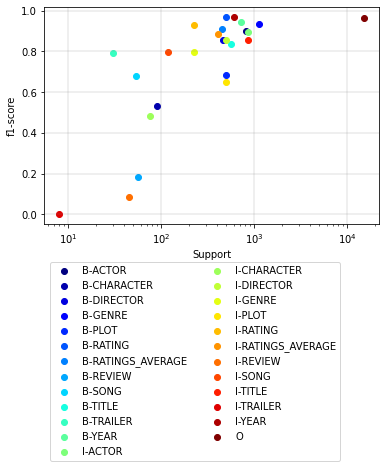

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig.set_size_inches(18.5, 10.5, forward=True)

x=x
y=y
classes = n
unique = np.unique(classes)
colors = [plt.cm.jet(i/float(len(unique)-1)) for i in range(len(unique))]
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend(bbox_to_anchor =(0.9, -0.15), ncol = 2)
plt.xscale("log")
plt.xlabel('Support')
plt.ylabel('f1-score')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
plt.show()

In [ ]:
type(tokens_stretched)


list

In [ ]:
type(trues_stretched)

list

In [ ]:
type(preds_stretched)

list

In [ ]:
import pandas as pd
df_to_compare=pd.DataFrame()
df_to_compare = pd.DataFrame(list(zip(tokens_stretched, trues_stretched, preds_stretched)),columns=['Token','Trues','Preds'])
df_to_compare.to_csv('/content/drive/My Drive/DAAN888/Results/NER_using_Elmo_each_token_latest.csv')

In [ ]:
df_to_compare

,Token,Trues,Preds
0,are,O,O
1,there,O,O
2,any,O,O
3,good,O,O
4,romantic,B-GENRE,B-GENRE
...,...,...,...
24681,movie,O,O
24682,about,O,O
24683,captain,B-CHARACTER,B-CHARACTER
24684,jack,I-CHARACTER,I-CHARACTER


In [ ]:
rslt_df = df_to_compare[df_to_compare['Trues'] != df_to_compare['Preds']] 
rslt_df

,Token,Trues,Preds
7,right,B-YEAR,O
8,now,I-YEAR,O
15,that,I-PLOT,O
16,talk,I-PLOT,O
33,recently,B-YEAR,O
...,...,...,...
24659,the,B-TITLE,O
24660,good,I-TITLE,O
24662,review,B-REVIEW,I-TITLE
24673,indiana,B-CHARACTER,B-ACTOR


In [ ]:
len(rslt_df)

1813

In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=19c8a779fec836ecf213b139c112a6c797958ddeb008d4a2b18a56843fda672a
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
seq_preds = []
for doc in trim_preds:
  seq_preds.append([idx2tag[val] for val in doc])

In [ ]:
seq_preds[0]

['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'O', 'O']

In [ ]:
from seqeval.metrics import classification_report as classification_report_seqeval

f = open(model_dir + model_name  + 'seq_class_report_test.txt', 'w') 

seq_class_report = classification_report_seqeval(dataset['test_labels'], seq_preds)
print(seq_class_report, file=f ) 

f.close() 
print(seq_class_report)

                 precision    recall  f1-score   support

          ACTOR       0.82      0.92      0.87       812
      CHARACTER       0.56      0.42      0.48        90
       DIRECTOR       0.82      0.81      0.81       456
          GENRE       0.89      0.92      0.90      1117
           PLOT       0.63      0.59      0.61       491
         RATING       0.93      0.93      0.93       500
RATINGS_AVERAGE       0.82      0.85      0.83       451
         REVIEW       0.13      0.05      0.08        56
           SONG       0.45      0.46      0.46        54
          TITLE       0.70      0.71      0.71       562
        TRAILER       0.82      0.77      0.79        30
           YEAR       0.93      0.93      0.93       720

      micro avg       0.82      0.83      0.83      5339
      macro avg       0.71      0.70      0.70      5339
   weighted avg       0.81      0.83      0.82      5339



In [ ]:
import pandas as pd
report_2 = classification_report_seqeval(dataset['test_labels'], seq_preds, output_dict=True)
df_report_2 = pd.DataFrame(report_2).transpose()
df_report_2

,precision,recall,f1-score,support
ACTOR,0.817486,0.921182,0.866242,812.0
CHARACTER,0.558824,0.422222,0.481013,90.0
DIRECTOR,0.815385,0.813596,0.814490,456.0
GENRE,0.887543,0.918532,0.902772,1117.0
PLOT,0.633406,0.594705,0.613445,491.0
RATING,0.929860,0.928000,0.928929,500.0
RATINGS_AVERAGE,0.815678,0.853659,0.834236,451.0
REVIEW,0.130435,0.053571,0.075949,56.0
SONG,0.454545,0.462963,0.458716,54.0
TITLE,0.704745,0.713523,0.709107,562.0


In [ ]:
df_report_2.reset_index(inplace=True)
df_report_2

,index,precision,recall,f1-score,support
0,ACTOR,0.817486,0.921182,0.866242,812.0
1,CHARACTER,0.558824,0.422222,0.481013,90.0
2,DIRECTOR,0.815385,0.813596,0.814490,456.0
3,GENRE,0.887543,0.918532,0.902772,1117.0
4,PLOT,0.633406,0.594705,0.613445,491.0
5,RATING,0.929860,0.928000,0.928929,500.0
6,RATINGS_AVERAGE,0.815678,0.853659,0.834236,451.0
7,REVIEW,0.130435,0.053571,0.075949,56.0
8,SONG,0.454545,0.462963,0.458716,54.0
9,TITLE,0.704745,0.713523,0.709107,562.0


In [ ]:
x=df_report_2['support'][0:12]
y=df_report_2['f1-score'][0:12]
n=df_report_2['index'][0:12]
n

0               ACTOR
1           CHARACTER
2            DIRECTOR
3               GENRE
4                PLOT
5              RATING
6     RATINGS_AVERAGE
7              REVIEW
8                SONG
9               TITLE
10            TRAILER
11               YEAR
Name: index, dtype: object

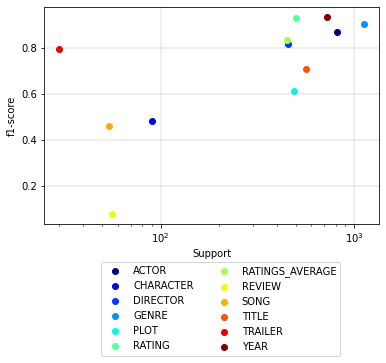

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig.set_size_inches(18.5, 10.5, forward=True)

x=x
y=y
classes = n
unique = np.unique(classes)
colors = [plt.cm.jet(i/float(len(unique)-1)) for i in range(len(unique))]
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend(bbox_to_anchor =(0.9, -0.15), ncol = 2)
plt.xscale("log")
plt.xlabel('Support')
plt.ylabel('f1-score')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
plt.show()